# Analysis of MLFlow experiment

In [1]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Replace with your experiment name or ID
experiment_name = "carbs_indefinite"
exp = mlflow.get_experiment_by_name(experiment_name)

runs = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    output_format="pandas"
)

runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.output,metrics.cost_sec,params.lr,params.gamma,params.q_lambda,params.epsilon,params.num_iterations,params.num_minibatches,params.update_epochs,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.user
0,cc0213bc0c7b4bbeb2a1734a1a874b62,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:29:14.251000+00:00,2025-09-01 17:29:14.293000+00:00,102.183594,32.066288,0.0005332084815399558,0.9306032321652615,0.8806339970194554,3.39752549254538e-08,127,11,1,trial_2131,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
1,66ad1a81ee0b4acfb580b4932721e897,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:24:50.631000+00:00,2025-09-01 17:24:50.668000+00:00,105.683594,31.453469,0.00040231355630512995,0.8907273218687047,0.8936589710254369,2.3732073409441883e-08,119,13,1,trial_2130,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
2,634b84d9a4634150907ecf38c8446401,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:20:32.627000+00:00,2025-09-01 17:20:32.664000+00:00,114.726562,105.672994,0.0005905665499275074,0.9178331692165488,0.9571090031582282,3.6905206036262855e-08,304,10,2,trial_2129,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
3,6b94c9f9c774425eb383671fec6acee7,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:14:53.782000+00:00,2025-09-01 17:14:53.820000+00:00,110.851562,39.069780,0.0004275821751900003,0.9554608027225212,0.9347854470612234,2.086653650051568e-08,149,13,1,trial_2128,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
4,96da3bf91a50479c93521d9d8eb0f7b1,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:10:28.335000+00:00,2025-09-01 17:10:28.372000+00:00,119.007812,65.664826,0.00045906683179154395,0.9175626820757259,0.9439867241763213,3.294726661426504e-08,280,9,1,trial_2127,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,28b2cddcae8543ac9478d12eda88c09a,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-05-06 22:52:40.412000+00:00,2025-05-06 22:52:40.425000+00:00,33.059998,48.253871,0.0006681811041565057,0.9733760797675235,0.9670931566932094,0.2197035529446635,50,10,2,trial_5,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,813a7dd5154b6459f2811510d3dbc47d3b113305,ferd
2761,36b06d12d2994d628d8a2203efc46baf,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-05-06 22:51:18.036000+00:00,2025-05-06 22:51:18.070000+00:00,37.689999,39.998360,0.0006502709868510596,0.977333044757794,0.9659860892347605,0.2736778510381808,37,8,2,trial_4,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,813a7dd5154b6459f2811510d3dbc47d3b113305,ferd
2762,b58b7d98449147f49c0b78f5ede7db52,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-05-06 22:50:33.937000+00:00,2025-05-06 22:50:33.945000+00:00,6.430000,84.140796,0.0003822157074977528,0.9696076495115418,0.6796372903902815,0.3743158108553737,51,3,2,trial_3,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,813a7dd5154b6459f2811510d3dbc47d3b113305,ferd
2763,d62fb19f5efc487789403f2f7d5087e0,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-05-06 22:49:05.413000+00:00,2025-05-06 22:49:05.421000+00:00,30.650000,50.244873,0.0004191993006014575,0.9832552144663319,0.9805080144891118,0.21455875620164983,63,1,3,trial_2,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,813a7dd5154b6459f2

In [3]:
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.output', 'metrics.cost_sec', 'params.lr',
       'params.gamma', 'params.q_lambda', 'params.epsilon',
       'params.num_iterations', 'params.num_minibatches',
       'params.update_epochs', 'tags.mlflow.runName',
       'tags.mlflow.source.name', 'tags.mlflow.source.type',
       'tags.mlflow.source.git.commit', 'tags.mlflow.user'],
      dtype='object')

In [4]:
# get me the first and last started at time
runs['start_time'] = pd.to_datetime(runs['start_time'], unit='ms')
runs['end_time'] = pd.to_datetime(runs['end_time'], unit='ms')
runs = runs.sort_values(by='start_time')
# remove all data before 2025-08-15
runs = runs[runs['start_time'] >= '2025-08-15']
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.output,metrics.cost_sec,params.lr,params.gamma,params.q_lambda,params.epsilon,params.num_iterations,params.num_minibatches,params.update_epochs,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.user
2142,d5574feeaade4e82a3b463d3d064e3f7,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:20:18.611000+00:00,2025-08-25 19:20:18.636000+00:00,99.855469,230.970237,7.427887971113485e-05,0.8302874123727914,0.9644748259837082,5.645465068402114e-05,253,8,6,trial_629,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5bba2014cb7d420453a8554a75b8dadb98de22bc,ferd
2141,54466ef08a6f4644a33c8afe63002097,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:24:50.995000+00:00,2025-08-25 19:24:51.026000+00:00,102.242188,204.349959,9.123003554757768e-05,0.9070583456080462,0.985659387340504,6.61545709594672e-05,261,9,6,trial_630,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5bba2014cb7d420453a8554a75b8dadb98de22bc,ferd
2140,efe69866f1d64e3f913eb406628517d5,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:50:26.462000+00:00,2025-08-25 19:50:26.496000+00:00,107.796875,187.962480,8.683483836896137e-05,0.8887777733129136,0.9885718167844247,5.8922606545262756e-05,281,10,6,trial_631,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
2139,e603c45e4c8f435aa173e1a640918db0,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:58:24.644000+00:00,2025-08-25 19:58:24.666000+00:00,105.523438,202.466505,7.391595194395425e-05,0.8819549167263463,0.9895978836213101,3.062381132039406e-05,278,11,6,trial_632,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
2138,c41a9b506f394fe792daf534b9c7392e,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 20:00:43.566000+00:00,2025-08-25 20:00:43.582000+00:00,7.910156,5.814767,0.0002823690600509741,0.984582569871261,0.9575325348682486,0.58258643430395,24,4,1,trial_1,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,96da3bf91a50479c93521d9d8eb0f7b1,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:10:28.335000+00:00,2025-09-01 17:10:28.372000+00:00,119.007812,65.664826,0.00045906683179154395,0.9175626820757259,0.9439867241763213,3.294726661426504e-08,280,9,1,trial_2127,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
3,6b94c9f9c774425eb383671fec6acee7,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:14:53.782000+00:00,2025-09-01 17:14:53.820000+00:00,110.851562,39.069780,0.0004275821751900003,0.9554608027225212,0.9347854470612234,2.086653650051568e-08,149,13,1,trial_2128,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
2,634b84d9a4634150907ecf38c8446401,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:20:32.627000+00:00,2025-09-01 17:20:32.664000+00:00,114.726562,105.672994,0.0005905665499275074,0.9178331692165488,0.9571090031582282,3.6905206036262855e-08,304,10,2,trial_2129,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
1,66ad1a81ee0b4acfb580b4932721e897,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:24:50.631000+00:00,2025-09-01 17:24:50.668000+00:00,105.683594,31.453469,0.00040231355630512995,0.8907273218687047,0.8936589710254369,2.3732073409441883e-08,119,13,1,trial_2130,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LO

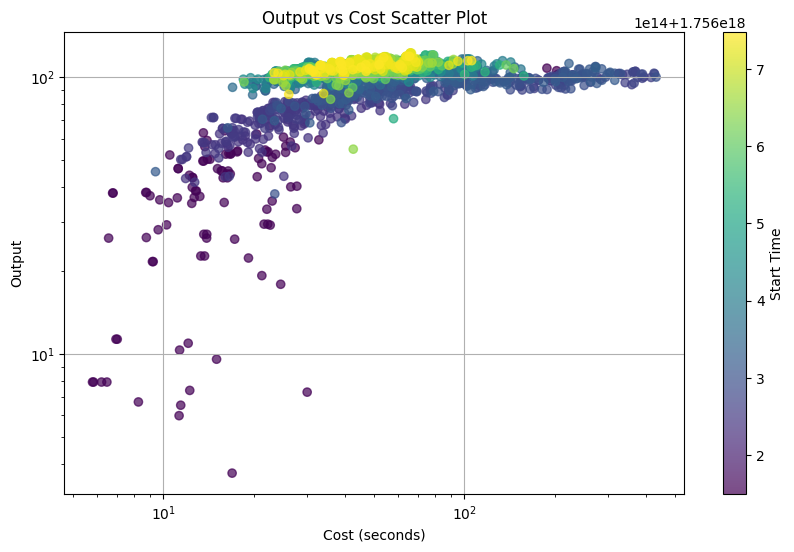

In [5]:
# plot scatter metrics.output vs metrics.cost_sec
plt.figure(figsize=(10, 6))
plt.scatter(runs['metrics.cost_sec'], runs['metrics.output'], alpha=0.7
              , c=pd.to_datetime(runs['start_time']).astype(int)  # color by start_time
              , cmap='viridis'
              )
plt.colorbar(label='Start Time')
plt.xlabel('Cost (seconds)')
plt.ylabel('Output')
plt.title('Output vs Cost Scatter Plot')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

In [6]:
# get the highest output run
best_output_run = runs.loc[runs['metrics.output'].idxmax()]
best_output_run

run_id                                            b2bda43236fe4146b62c24d6f8545c4f
experiment_id                                                   138486052850542536
status                                                                    FINISHED
artifact_uri                     file:///home/ferd/github/simple-rts-rl/mlruns/...
start_time                                        2025-09-01 07:54:30.025000+00:00
end_time                                          2025-09-01 07:54:30.059000+00:00
metrics.output                                                          122.164062
metrics.cost_sec                                                         66.212046
params.lr                                                     0.000775549169032303
params.gamma                                                    0.9635854021287515
params.q_lambda                                                 0.9365755209004949
params.epsilon                                              2.2540519159618335e-08
para

In [7]:
corr = runs.corr(numeric_only=True)["metrics.output"].sort_values(ascending=False)
print(corr)

metrics.output      1.000000
metrics.cost_sec    0.234988
Name: metrics.output, dtype: float64


In [8]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.output,metrics.cost_sec,params.lr,params.gamma,params.q_lambda,params.epsilon,params.num_iterations,params.num_minibatches,params.update_epochs,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.user
2142,d5574feeaade4e82a3b463d3d064e3f7,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:20:18.611000+00:00,2025-08-25 19:20:18.636000+00:00,99.855469,230.970237,7.427887971113485e-05,0.8302874123727914,0.9644748259837082,5.645465068402114e-05,253,8,6,trial_629,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5bba2014cb7d420453a8554a75b8dadb98de22bc,ferd
2141,54466ef08a6f4644a33c8afe63002097,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:24:50.995000+00:00,2025-08-25 19:24:51.026000+00:00,102.242188,204.349959,9.123003554757768e-05,0.9070583456080462,0.985659387340504,6.61545709594672e-05,261,9,6,trial_630,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5bba2014cb7d420453a8554a75b8dadb98de22bc,ferd
2140,efe69866f1d64e3f913eb406628517d5,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:50:26.462000+00:00,2025-08-25 19:50:26.496000+00:00,107.796875,187.962480,8.683483836896137e-05,0.8887777733129136,0.9885718167844247,5.8922606545262756e-05,281,10,6,trial_631,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
2139,e603c45e4c8f435aa173e1a640918db0,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 19:58:24.644000+00:00,2025-08-25 19:58:24.666000+00:00,105.523438,202.466505,7.391595194395425e-05,0.8819549167263463,0.9895978836213101,3.062381132039406e-05,278,11,6,trial_632,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
2138,c41a9b506f394fe792daf534b9c7392e,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 20:00:43.566000+00:00,2025-08-25 20:00:43.582000+00:00,7.910156,5.814767,0.0002823690600509741,0.984582569871261,0.9575325348682486,0.58258643430395,24,4,1,trial_1,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,96da3bf91a50479c93521d9d8eb0f7b1,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:10:28.335000+00:00,2025-09-01 17:10:28.372000+00:00,119.007812,65.664826,0.00045906683179154395,0.9175626820757259,0.9439867241763213,3.294726661426504e-08,280,9,1,trial_2127,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
3,6b94c9f9c774425eb383671fec6acee7,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:14:53.782000+00:00,2025-09-01 17:14:53.820000+00:00,110.851562,39.069780,0.0004275821751900003,0.9554608027225212,0.9347854470612234,2.086653650051568e-08,149,13,1,trial_2128,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
2,634b84d9a4634150907ecf38c8446401,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:20:32.627000+00:00,2025-09-01 17:20:32.664000+00:00,114.726562,105.672994,0.0005905665499275074,0.9178331692165488,0.9571090031582282,3.6905206036262855e-08,304,10,2,trial_2129,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,f75857a0b72281d98e5652d61411bd7ecb0fa1d1,ferd
1,66ad1a81ee0b4acfb580b4932721e897,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-09-01 17:24:50.631000+00:00,2025-09-01 17:24:50.668000+00:00,105.683594,31.453469,0.00040231355630512995,0.8907273218687047,0.8936589710254369,2.3732073409441883e-08,119,13,1,trial_2130,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LO

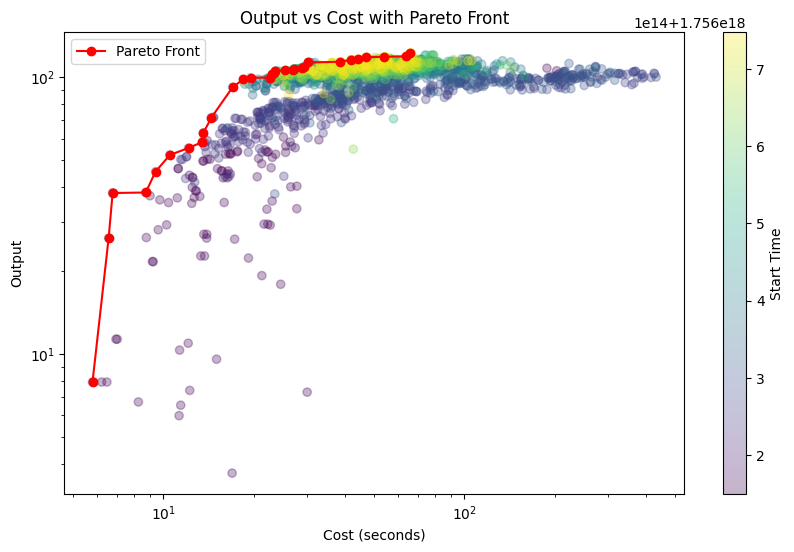

In [ ]:
def pareto_front(df, x_col="metrics.cost_sec", y_col="metrics.output"):
    # Sort ascending on cost, descending on output
    df_sorted = df.sort_values([x_col, y_col], ascending=[True, False])
    pareto = []
    best_y = -float("inf")
    for _, row in df_sorted.iterrows():
        if row[y_col] > best_y:
            pareto.append(row)
            best_y = row[y_col]
    return pd.DataFrame(pareto)

pareto_runs = pareto_front(runs)
plt.figure(figsize=(10, 6))
plt.scatter(runs['metrics.cost_sec'], runs['metrics.output'], alpha=0.3
                , c=pd.to_datetime(runs['start_time']).astype(int) 
                , cmap='viridis'
                )
plt.plot(pareto_runs['metrics.cost_sec'], pareto_runs['metrics.output'], color='red', marker='o', label='Pareto Front')
plt.colorbar(label='Start Time')
plt.xlabel('Cost (seconds)')
plt.ylabel('Output')
plt.title('Output vs Cost with Pareto Front')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [10]:
pareto_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.output,metrics.cost_sec,params.lr,params.gamma,params.q_lambda,params.epsilon,params.num_iterations,params.num_minibatches,params.update_epochs,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.user
2138,c41a9b506f394fe792daf534b9c7392e,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 20:00:43.566000+00:00,2025-08-25 20:00:43.582000+00:00,7.910156,5.814767,0.0002823690600509741,0.984582569871261,0.9575325348682486,0.58258643430395,24,4,1,trial_1,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
2056,af478319f3d74bfd8ddf5de42c40e3df,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 21:05:21.800000+00:00,2025-08-25 21:05:21.816000+00:00,26.207031,6.577951,0.00013303252208947947,0.681143632621739,0.9812894102149126,0.26389972189687777,18,1,4,trial_75,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
2095,ff519f53735a4eb0bef1459cdcc227a1,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 20:36:23.182000+00:00,2025-08-25 20:36:23.199000+00:00,38.136719,6.782179,0.000122554945470303,0.7443115888310352,0.9907510917085098,0.33997939777643005,18,2,4,trial_36,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
2052,4f250a7c42ae426ca39ca06d3c90ce47,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 21:07:56.338000+00:00,2025-08-25 21:07:56.355000+00:00,38.304688,8.736773,0.00010614004996107442,0.6226132249816388,0.9918311739587751,0.18052058035807828,26,3,3,trial_79,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
1490,059637bcb75d4dc69813d5e8e8dea9ab,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-27 18:56:14.245000+00:00,2025-08-27 18:56:14.270000+00:00,45.546875,9.414913,0.00039933961230482947,0.6035940441498422,0.9241026437780288,0.011431362246647123,42,3,1,trial_641,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,da4dc9c6a809d1fb341284ed18b94ea222d19435,ferd
2042,4d80d70111074c95a13a8abbc1a8103e,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 21:15:27.472000+00:00,2025-08-25 21:15:27.494000+00:00,52.339844,10.502769,0.00012836034107746117,0.4009251299631573,0.9916956925002024,0.1506810939193819,31,3,3,trial_89,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
1871,91c4e4228ed24afd9108b7047f348c9b,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-26 23:27:29.655000+00:00,2025-08-26 23:27:29.680000+00:00,55.476562,12.123092,0.00012433457199279352,0.6487641862921301,0.957671015610688,0.008332588994924282,50,6,1,trial_260,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,da4dc9c6a809d1fb341284ed18b94ea222d19435,ferd
1998,82cf4860ca6346978ef59ad16da1ba48,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-26 20:33:47.708000+00:00,2025-08-26 20:33:47.725000+00:00,58.265625,13.461135,0.00011175726292861275,0.7898417375916024,0.9753344932653807,0.0990180869862454,39,6,2,trial_133,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,da4dc9c6a809d1fb341284ed18b94ea222d19435,ferd
2057,de4cda18679c418aa1dae834a980d46e,138486052850542536,FINISHED,file:///home/ferd/github/simple-rts-rl/mlruns/...,2025-08-25 21:04:41.419000+00:00,2025-08-25 21:04:41.438000+00:00,62.933594,13.579659,0.00014307398849154618,0.6805244443724663,0.9862592420412504,0.14562431797755332,35,2,4,trial_74,/home/ferd/github/simple-rts-rl/src/rl/carbs_p...,LOCAL,5d6701b758bf5be4d5237e4c6628e3167348cfb4,ferd
1854,88066c88224e43b78efa7e99e1b6e393,138486052850542536,FINISHED,file:///h

In [11]:
from sklearn.ensemble import RandomForestRegressor

param_cols = [c for c in runs.columns if c.startswith("params.")]
X = runs[param_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
y = runs["metrics.output"]

model = RandomForestRegressor(n_estimators=200, random_state=0)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=param_cols).sort_values(ascending=False)
print(importances)

params.epsilon            0.627965
params.num_iterations     0.178888
params.gamma              0.125652
params.num_minibatches    0.028961
params.lr                 0.015439
params.update_epochs      0.013625
params.q_lambda           0.009469
dtype: float64


In [27]:
top = runs.nlargest(int(len(runs)*0.01), "metrics.output")
top_params = top[param_cols].mode()
top_params

,params.lr,params.gamma,params.q_lambda,params.epsilon,params.num_iterations,params.num_minibatches,params.update_epochs
0,0.0008030091559080904,0.9207063544292375,0.9575572403046796,9.087041868249922e-06,277,11,1


In [16]:
param_cols

['params.lr',
 'params.gamma',
 'params.q_lambda',
 'params.epsilon',
 'params.num_iterations',
 'params.num_minibatches',
 'params.update_epochs']

In [ ]:
import itertools

search_space = {
    "params.lr": [0.000803, 0.0005, 0.0007, 0.0009, 0.001, 0.002],
    "params.gamma": [0.85, 0.9, 0.92, 0.95, 0.99],
    "params.q_lambda": [0.95755,0.9,0.95,0.99],
    "params.epsilon": [0.00001, 0.00005, 0.0001, 0.0005],
    "params.num_iterations": [50,100,200,300,1000],
    "params.num_minibatches": [8,9,10,11,12,13],
    "params.update_epochs": [1,2],
}

grid = pd.DataFrame(
    list(itertools.product(*search_space.values())),
    columns=search_space.keys()
)

preds = model.predict(grid)
grid["pred_output"] = preds

grid.sort_values("pred_output", ascending=False).head(10)

,params.lr,params.gamma,params.q_lambda,params.epsilon,params.num_iterations,params.num_minibatches,params.update_epochs,pred_output
1978,0.000803,0.92,0.95755,0.00001,1000,13,1,116.481855
1976,0.000803,0.92,0.95755,0.00001,1000,12,1,116.470020
1974,0.000803,0.92,0.95755,0.00001,1000,11,1,116.403164
1966,0.000803,0.92,0.95755,0.00001,300,13,1,116.323457
1964,0.000803,0.92,0.95755,0.00001,300,12,1,116.304609
1962,0.000803,0.92,0.95755,0.00001,300,11,1,116.244102
2038,0.000803,0.92,0.95755,0.00005,1000,13,1,116.208457
2036,0.000803,0.92,0.95755,0.00005,1000,12,1,116.154551
2034,0.000803,0.92,0.95755,0.00005,1000,11,1,116.147886
2026,0.000803,0.92,0.95755,0.00005,300,13,1,116.069141
